In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris 
from scipy.sparse import csr_matrix
from lib.gradient_tools import BasicGradientUpdater
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics.pairwise import linear_kernel
from lib.sparse_tools import sparse_clip, sparse_pos_clip, dense_pos_clip, sparse_sparse_dot, dense_sparse_add, \
                             dense_sparse_mul, sparse_sub_with_clip

In [2]:
iris_data = load_iris()

In [3]:
km = csr_matrix(linear_kernel(iris_data["data"]))
n = km.shape[0]
y = iris_data["target"]
y[y > 0] = 1

-----

## SkLearn

In [4]:
%%time
y = [0] * 50 + [1]*100
clf = SVC(kernel="precomputed", probability=True)
clf.fit(km.toarray(), y)
print(classification_report(y, clf.predict(km.toarray())))
print(roc_auc_score(y, clf.predict_proba(km.toarray())[:, 1]))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00       100

avg / total       1.00      1.00      1.00       150

1.0
CPU times: user 6.14 ms, sys: 1.63 ms, total: 7.76 ms
Wall time: 8.07 ms


In [5]:
clf.support_

array([23, 41, 98], dtype=int32)

## Ours

In [39]:
# Input:
# km: csr_matrix
# y: np.array

C = 1.0
γ = 500000. # O(n)
L1 = 2*γ
ε = 1e-3
n_iter = 500


inv2nC = 1. / (2 * n * C)
invL1 = 1. / L1
fracCL1 = C / L1

y = np.array([+1.] * 50 + [-1.] * 100)

# γy = γ * y

In [40]:
def grad_f(x):
    t = x.copy()
    t.data -= 1 / (2 * n * C)
    return (-csr_matrix([1] * n).T + km.multiply(y.reshape(1, -1) * y.reshape(-1, 1)).dot(x.T) + \
           γ*sparse_clip(-x.T, 0, None) + γ*sparse_clip(t.T, 0, None)).T

In [41]:
%%time

# Initialize gradient heap

ν = csr_matrix(([0., 0.], [1, 2], [0, 2]), shape=(1, n))

# grad1 = dense_sparse_add(-y, 2 * (km[0] - km[1]))

# yν_ = dense_sparse_mul(y, ν)
# yν1 = sparse_pos_clip(-yν_)
# yν2 = sparse_sub_with_clip(yν_, inv2nC)
# grad2 = dense_sparse_mul(γy, yν1 + yν2)

# grad = dense_sparse_add(grad1, grad2)
# min_heap = BasicGradientUpdater(grad)
# max_heap = BasicGradientUpdater(-grad)

# Iterate until stopping criteria is met

norms = []
h_vals = []

for t in range(n_iter):
    ν_prev = ν.copy()
    
    current_grad = dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν)))
    norms.append(sparse.linalg.norm(current_grad))
    
    min_ix = current_grad.argmin()
    max_ix = current_grad.argmax()
    min_val = current_grad.min()
    max_val = current_grad.max()
    h_val = fracCL1 * (max_val - min_val)
    h_vec = csr_matrix(([-h_val, +h_val], [min_ix, max_ix], [0, 2]), shape=(1, n))
    h_vec.sort_indices()
    h_vals.append(h_val)

    ν += h_vec
    assert np.abs(ν.sum()) <= 1e-6

    # Gradient update
#     νinvL1h = ν_prev + invL1 * h_vec
#     δ1 = (2 * h_val / L1) * (km[min_ix] - km[max_ix])
#     δ21 =  sparse_pos_clip(dense_sparse_mul(-y, νinvL1h))
#     δ22 = -sparse_pos_clip(dense_sparse_mul(-y, ν_prev))
#     δ23 =  sparse_sub_with_clip(dense_sparse_mul(y, νinvL1h), inv2nC)
#     δ24 = -sparse_sub_with_clip(dense_sparse_mul(y, ν_prev), inv2nC)
#     δ2 = dense_sparse_mul(γy, δ21 + δ22 + δ23 + δ24)
#     δ = δ1 + δ2
#     δ = np.asarray(dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν))) - min_heap.get())[0]

λ = dense_sparse_mul(y, ν)

CPU times: user 2.63 s, sys: 33.4 ms, total: 2.66 s
Wall time: 2.69 s


In [42]:
λ.toarray()

array([[ -2.67079248e-06,  -2.67079031e-06,  -2.67097791e-06,
         -2.67081022e-06,  -2.67084416e-06,  -2.66659215e-06,
         -2.67089902e-06,  -2.67072167e-06,  -2.66714917e-06,
         -2.67074963e-06,  -2.67062926e-06,  -2.67069045e-06,
         -2.67084680e-06,  -2.66751083e-06,  -2.66700612e-06,
         -2.67054916e-06,  -2.66694899e-06,  -2.67075172e-06,
         -2.66651489e-06,  -2.67069795e-06,  -2.66659565e-06,
         -2.66684708e-06,  -2.66753317e-06,  -2.67036206e-06,
         -2.66663181e-06,  -2.67056319e-06,  -2.67055332e-06,
         -2.66688677e-06,  -2.67073961e-06,  -2.67070412e-06,
         -2.66689317e-06,  -2.67051102e-06,  -2.67078759e-06,
         -2.67076352e-06,  -2.66693249e-06,  -2.67096981e-06,
         -2.67074738e-06,  -2.67074418e-06,  -2.67104331e-06,
         -2.67067979e-06,  -2.67088480e-06,  -2.67087583e-06,
         -2.67107715e-06,  -2.66668091e-06,  -2.66654276e-06,
         -2.66697094e-06,  -2.66686235e-06,  -2.66712874e-06,
        

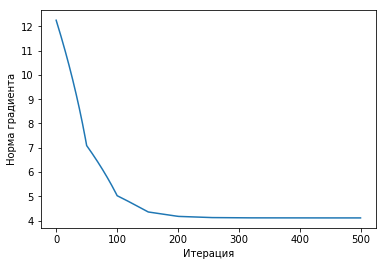

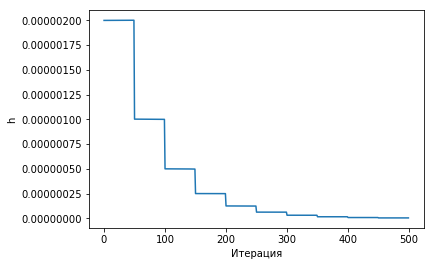

In [43]:
plt.xlabel("Итерация")
plt.ylabel("Норма градиента")
plt.plot(norms)
plt.show()
plt.xlabel("Итерация")
plt.ylabel("h")
plt.plot(h_vals)
plt.show()

(array([  50.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  100.]),
 array([ -2.67107715e-06,  -2.27005248e-06,  -1.86902780e-06,
         -1.46800312e-06,  -1.06697844e-06,  -6.65953758e-07,
         -2.64929078e-07,   1.36095601e-07,   5.37120281e-07,
          9.38144960e-07,   1.33916964e-06]),
 <a list of 10 Patch objects>)

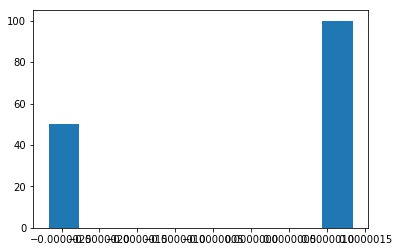

In [74]:
plt.hist(ν.data)

(array([ 26.,   5.,   0.,   0.,   0.,   0.,   0.,   2.,   3.,  14.]),
 array([ -2.67107715e-06,  -2.67062093e-06,  -2.67016470e-06,
         -2.66970848e-06,  -2.66925225e-06,  -2.66879602e-06,
         -2.66833980e-06,  -2.66788357e-06,  -2.66742735e-06,
         -2.66697112e-06,  -2.66651489e-06]),
 <a list of 10 Patch objects>)

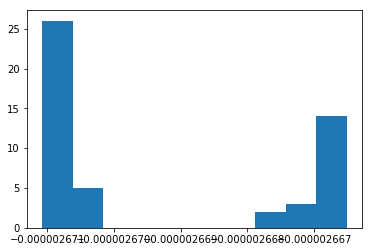

In [72]:
plt.hist(λ.toarray()[0][y > 0])

(array([  3.,   4.,   6.,  14.,   9.,  11.,  19.,  20.,   9.,   5.]),
 array([ -1.33916964e-06,  -1.33836906e-06,  -1.33756847e-06,
         -1.33676789e-06,  -1.33596730e-06,  -1.33516672e-06,
         -1.33436614e-06,  -1.33356555e-06,  -1.33276497e-06,
         -1.33196438e-06,  -1.33116380e-06]),
 <a list of 10 Patch objects>)

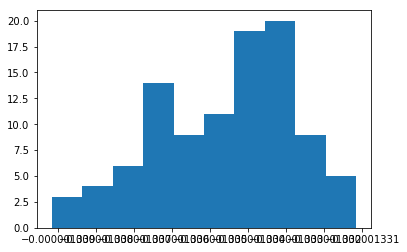

In [73]:
plt.hist(λ.toarray()[0][y < 0])

---